# **Import libraries**

In [10]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# **Load dataset**

In [19]:
df = pd.read_excel("/content/test-dataset.xlsx")
df.head()

,Unnamed: 0,household_id,total_income,union_name,user_id,profile_name,father_name,mother_name,birthday,age,...,RESULT_STAT_BMI,SUGAR,TAG_NAME,RESULT_STAT_SUGAR,PULSE_RATE,RESULT_STAT_PR,SPO2,RESULT_STAT_SPO2,MUAC,RESULT_STAT_MUAC
0,1,241175,Lower class,KOLA,988794,মো: সাগরহোসেন,0.0,0.0,2001-11-05 18:00:00,19,...,NaN,NaN,NaN,NaN,96.0,Normal,97.0,Normal,NaN,NaN
1,2,241176,Lower class,KOLA,988796,মোছা:তামান্না,0.0,0.0,2000-06-18 18:00:00,20,...,NaN,NaN,NaN,NaN,89.0,Normal,NaN,NaN,NaN,NaN
2,3,241179,Lower class,KOLA,988802,শুকুরুচন্দ্র,0.0,0.0,1978-06-04 18:00:00,42,...,NaN,NaN,NaN,NaN,69.0,Normal,NaN,NaN,NaN,NaN
3,4,241180,Lower class,KOLA,988807,দিপালীরাণী,0.0,0.0,1956-02-02 18:00:00,64,...,NaN,8.72,Random,Normal,85.0,Normal,NaN,NaN,NaN,NaN
4,5,241181,Lower class,KOLA,988809,বুলবুলি,0.0,0.0,1996-12-25 18:00:00,23,...,NaN,NaN,NaN,NaN,101.0,High,NaN,NaN,NaN,NaN


# **Basic information**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  29999 non-null  int64  
 1   household_id                29999 non-null  int64  
 2   total_income                29999 non-null  object 
 3   union_name                  29999 non-null  object 
 4   user_id                     29999 non-null  int64  
 5   profile_name                29999 non-null  object 
 6   father_name                 25561 non-null  object 
 7   mother_name                 25547 non-null  object 
 8   birthday                    29999 non-null  object 
 9   age                         29999 non-null  int64  
 10  gender                      29999 non-null  object 
 11  is_poor                     29999 non-null  int64  
 12  is_freedom_fighter          29999 non-null  int64  
 13  had_stroke                  299

# **Statistical analysis (Chi-square test)**

In [4]:
target = 'has_cardiovascular_disease'
drop_cols = ['Unnamed: 0', 'household_id', 'union_name', 'user_id', 'profile_name',
             'father_name', 'mother_name', 'birthday', 'disabilities_name', 'MUAC', 'RESULT_STAT_MUAC']


X = df.drop(columns=[target] + drop_cols, errors='ignore')
y = df[target]

# Encode categorical variables (for chi2)
for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))


# Fill NaN values because chi2 cannot handle NaNs
X = X.fillna(0)

# Apply chi-square test using sklearn chi2 (works for non-negative data)
chi2_scores, p_values = chi2(X, y)

chi2_results_sklearn = pd.DataFrame({
    'Feature': X.columns,
    'Chi2': chi2_scores,
    'p_value': p_values
}).sort_values('p_value')

chi2_results_sklearn

,Feature,Chi2,p_value
5,had_stroke,1370.607608,5.122793e-300
15,SUGAR,240.692706,2.777574e-54
7,profile_hypertensive,229.184231,8.979444e-52
11,HEIGHT,189.166299,4.834061e-43
6,diabetic,101.711917,6.421289e-24
1,age,81.150821,2.091321e-19
8,SYSTOLIC,68.836254,1.069877e-16
12,WEIGHT,64.029971,1.225408e-15
9,DIASTOLIC,53.111873,3.150821e-13
13,BMI,29.100279,6.872708e-08


# **Validate using mutual information**

In [18]:
from sklearn.feature_selection import mutual_info_classif

# Mutual Information calculation
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi2_Score': chi2_scores,
    'Chi2_p_value': p_values,
    'MI_Score': mi_scores
}).sort_values('Chi2_Score', ascending=False)

comparison_df

,Feature,Chi2_Score,Chi2_p_value,MI_Score
5,had_stroke,1370.607608,5.122793e-300,0.000846
15,SUGAR,240.692706,2.777574e-54,0.000120
7,profile_hypertensive,229.184231,8.979444e-52,0.001579
11,HEIGHT,189.166299,4.834061e-43,0.000061
6,diabetic,101.711917,6.421289e-24,0.000627
1,age,81.150821,2.091321e-19,0.000719
8,SYSTOLIC,68.836254,1.069877e-16,0.000211
12,WEIGHT,64.029971,1.225408e-15,0.000369
9,DIASTOLIC,53.111873,3.150821e-13,0.000277
13,BMI,29.100279,6.872708e-08,0.000000


# **Final significant selected features**

In [6]:
# Select significant features
sig_features = comparison_df[
    (comparison_df['Chi2_p_value'] < 0.05) &
    (comparison_df['MI_Score'] > 0)
]['Feature'].tolist()

print("Final Selected Significant Features:")
print(sig_features)

Final Selected Significant Features:
['had_stroke', 'SUGAR', 'profile_hypertensive', 'HEIGHT', 'diabetic', 'age', 'SYSTOLIC', 'WEIGHT', 'DIASTOLIC', 'total_income']


# **Manage class imbalance**

In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_select = X[sig_features]
y = df[target]

X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_select, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Model performance with significant features**

In [8]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print("\nModel Performance with Significant Features:")
results_df


Model Performance with Significant Features:


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.996246,0.994053,0.998506,0.996275
1,Gradient Boosting,0.913232,0.905102,0.924328,0.914614
2,XGBoost,0.992825,0.992374,0.993362,0.992868


# **Prediction of the high performing model**

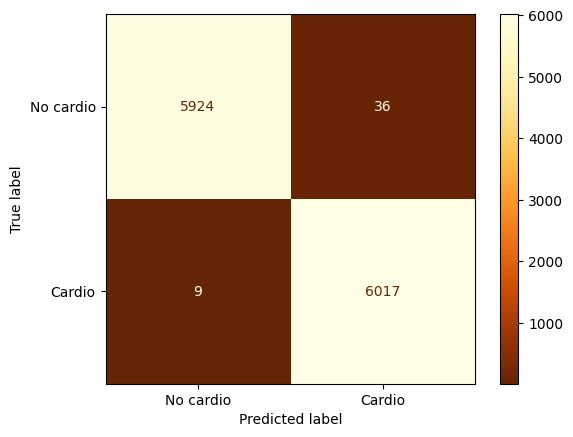

In [17]:
y_pred = models["Random Forest"].predict(X_test)
cnf = confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(cnf,display_labels = ['No cardio', 'Cardio']).plot(cmap='YlOrBr_r')
plt.savefig('confusion_matrix.png')
plt.show()